# Train

This notebooks trains a convolutional neural network (CNN) to segment UAV
imagery into `ground`, `water`, and `building` classes. This process is called
*semantic segmentation*.

For a demonstration of the models that are trained in this notebook, see
[inference.ipynb](inference.ipynb) instead.

The purpose of this functionality for the Lakehopper system is twofold:
- Provide awareness of the situation under the drone at the moment of flight
  ('in-situ'). This is as opposed to beforehand (when a certain dataset was
  captured or when the drone previously collected data). A lake might have dried
  up or a boat might be present where it wasn't previously.
- Provide a wide-area map based on orthographic imagery with features that are
  relevant to lakehopper. Other maps do not necessarily have the same feature
  definitions as lakehopper. The `water` class for Lakehopper refers to a body
  of surface water where autonomous landing is possible. Swamps or water
  obscured by bridges or vegetation do not fit this definition. They are however
  still classified as 'water' on most topographic maps.

{include-in-output}`/dissertation.pdf`
More information on everything from the model architecture to the motivation for
using a CNN can be found in my 2022 master's dissertation [*Autonomous Path Planning
and Landing Site Selection for Aquatic UAV*](/dissertation.pdf).
  
The dataset is too large to upload via cloud storage (58.6 GiB). Please contact
pieter@pfiers.net for a copy.

## Google Colaboratory Setup

Running in [Google Colab](https://colab.research.google.com/) is useful to
inspect the models and preview the dataset. To train the model however, a more
powerful runtime is necessary (like a GCE VPS with a TPU).

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  sys.path.insert(0, "/content/drive/MyDrive/lh-train/lakehopper_semseg")
  from google.colab import drive
  drive.mount('/content/drive')

## Jupyter Notebook Setup

In [2]:
from env_utils import is_notebook, find_repo
from pathlib import Path
IS_NOTEBOOK = is_notebook()
REPO_ROOT = find_repo(Path.cwd())
if IS_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2

## Imports

In [3]:
from datetime import datetime
from itertools import islice
import sys, os, csv, json

from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.metrics as k_metrics
import tensorflow.keras.activations as k_activations
from tensorflow.python.distribute.tpu_strategy import TPUStrategy

2022-09-24 11:11:41.863570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 11:11:42.856209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 11:11:42.856230: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-24 11:11:42.970985: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-24 11:11:45.044104: W tensorflow/stream_executor/platform/de

In [4]:
# Convenience methods
from visualize import show
from tpu import resolve_tpu_strategy, get_tpu_devices
from dataset import load_dataset, split_dataset_paths, read_metadata, has_all_classes, has_any_of_classes, categorical_to_single_label_mask_tf, read_metadata, categorical_to_one_hot_label_mask, single_hot_to_categorical
from masks import colorize_byte_mask
from augment import Augment
from models.create import create_model, compile_model

## TPU Setup

To speed up model training, we use [Google Cloud Platform](https://cloud.google.com/)'s "[TPU's](https://cloud.google.com/tpu)". TPU's use a machine learning ASIC.

In [5]:
USE_TPU = os.environ.get('USE_TPU', False)
if os.environ.get('USE_TPU', False):
  PARALLEL_OPS = tf.data.AUTOTUNE
  tpu_strategy = resolve_tpu_strategy('us-node')
  nbro_tpu_devices = len(get_tpu_devices())
  print(f"{nbro_tpu_devices} TPU devices connected!")
else:
  PARALLEL_OPS = None
  tpu_strategy = None

## Dataset Preparation

In [6]:
CLASSES = ["water", "building"]
IMAGE_SIZE = (224, 224)

In [7]:
if IN_COLAB:
    DATASET_FOLDER = "/content/drive/MyDrive/lh-train/tfr"
elif USE_TPU:
    DATASET_FOLDER = "gs://semseg-data-aggregated-1/tfr"
elif REPO_ROOT is not None:
    DATASET_FOLDER = str(REPO_ROOT / "vision/datasets/aggregated/tfr")
metadata_file_path = DATASET_FOLDER + "/metadata.json"
metadata = read_metadata(metadata_file_path)
TFR_PATTERN = DATASET_FOLDER + "/*.tfr"

if len(CLASSES) == 1:
    def should_include_chip(chip_classes):
        return all(class_ in chip_classes for class_ in CLASSES)
else:
    def should_include_chip(chip_classes):
        return any(class_ in chip_classes for class_ in CLASSES)

stem_nbro_label_pixels = metadata["nbroLabelPixels"]
chip_w, chip_h = tuple(metadata["size"])
chip_nro_pixels = chip_w * chip_h
total_nbro_label_pixels = {}
applicable_chips = set()
for stem, nbro_label_pixels in stem_nbro_label_pixels.items():
    if should_include_chip(nbro_label_pixels.keys()):
        applicable_chips.add(stem)
        for class_, nbro_pixels in nbro_label_pixels.items():
            total_nbro_label_pixels[class_] = total_nbro_label_pixels.get(class_, 0) + nbro_pixels
        nbro_labelled_pixels = sum(nbro_label_pixels.values())
        nbro_unlabelled_pixels = chip_nro_pixels - nbro_labelled_pixels
        total_nbro_label_pixels["background"] = total_nbro_label_pixels.get("background", 0) + nbro_unlabelled_pixels
print(total_nbro_label_pixels)
tfr_paths = list(filter(
    lambda p: Path(p).stem in applicable_chips,
    tf.io.gfile.glob(TFR_PATTERN)
))

{'building': 25987352, 'background': 173127015, 'water': 52975633}


In [8]:
TRAIN_RATIO = 0.75
VALIDATION_RATIO = 0.24 # Remaining 6% is test
train_paths, validate_paths, test_paths = split_dataset_paths(tfr_paths, TRAIN_RATIO, VALIDATION_RATIO)
print(f"Found {len(tfr_paths)} tfrs. Splitting into {len(train_paths)} training, {len(validate_paths)} validation, and {len(test_paths)} test tfrs")

Found 2801 tfrs. Splitting into 2100 training, 672 validation, and 29 test tfrs


## Load dataset

In [9]:
# The weights for each class are inversely proportional to the number of pixels
# of that class present in the dataset, thereby making correct predictions for
# underrepresented classes more important
CLASS_WEIGHTS = 1 / tf.constant([total_nbro_label_pixels["background"], *(total_nbro_label_pixels[_class] for _class in CLASSES)])
# Normalize the weights so that they sum to 1
CLASS_WEIGHTS = CLASS_WEIGHTS/tf.reduce_sum(CLASS_WEIGHTS)
print(f"Class weights: {CLASS_WEIGHTS.numpy()} for classes: {['background', *CLASSES]}")

def add_sample_weights(image, label):
    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights`
    sample_weights = tf.gather(CLASS_WEIGHTS, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

Class weights: [0.09149112 0.29899756 0.60951132] for classes: ['background', 'water', 'building']


2022-09-24 11:11:47.847361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 11:11:47.848697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 11:11:47.849289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-24 11:11:47.849524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-24 11:11:47.849649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
BATCH_SIZE = 64  # Using TPU v3-8 device => must be divisible by 8 for sharding
BUFFER_SIZE = 1000

def transform_mask(img, mask, weights = None):
    if len(CLASSES) == 1:
        mask_transformed = categorical_to_single_label_mask_tf(CLASSES.index("water") + 1, mask)
    else:
        mask_transformed = categorical_to_one_hot_label_mask(len(CLASSES) + 1, mask)
    
    if weights is None:
        return img, mask_transformed
    else:
        return img, categorical_to_one_hot_label_mask(len(CLASSES) + 1, mask), weights

# Dataset generation *must* come after tpu resolution
training_dataset = (
    load_dataset(train_paths, IMAGE_SIZE, PARALLEL_OPS)
    .map(add_sample_weights)
    .map(transform_mask)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_dataset = (
    load_dataset(validate_paths, IMAGE_SIZE, PARALLEL_OPS)
    .map(transform_mask)
    .cache()
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_dataset = (
    load_dataset(test_paths, IMAGE_SIZE, PARALLEL_OPS)
    .map(transform_mask)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualise Training Data

2022-09-24 11:11:53.957437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


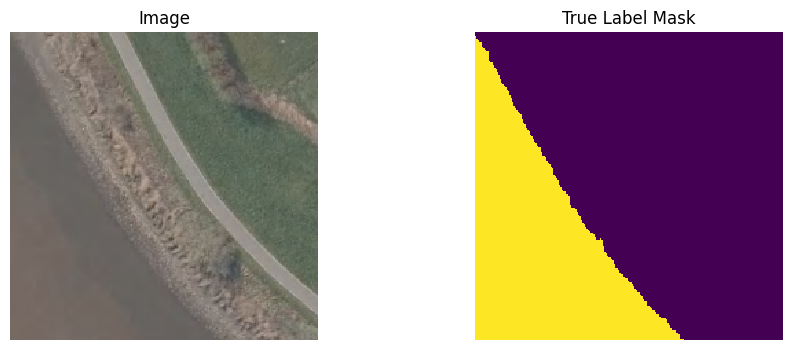

In [11]:
if IS_NOTEBOOK:
    sample_images_batch, sample_labels_batch, _ = next(iter(training_dataset))
    sample_images = iter(sample_images_batch)
    sample_labels = iter(sample_labels_batch)
    show([(next(sample_images), single_hot_to_categorical(len(CLASSES), 1, next(sample_labels)))])

## Create model

In [14]:
input_shape = IMAGE_SIZE + (3,)
print(f"Input shape: {input_shape}")

def create_and_compile(encoder, decoder):
    model = create_model(CLASSES, input_shape, encoder, decoder)
    model = compile_model(model, CLASSES)
    return model

encoder = os.environ.get('ENCODER', 'EfficientNetB3')
decoder = os.environ.get('DECODER', 'FCN')
if tpu_strategy is not None:
    with tpu_strategy.scope():
        model = create_and_compile(encoder, decoder)
else:
    model = create_and_compile(encoder, decoder)

print(f"Model created with encoder: {encoder} and decoder: {decoder}")
if IS_NOTEBOOK:
    model.summary()

Input shape: (224, 224, 3)
Got kwargs: {}
Model created with encoder: EfficientNetB3 and decoder: FCN
Model: "FCN_EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                            

In [13]:
PLOT_MODEL = os.environ.get('PLOT_MODEL', False)
if PLOT_MODEL:
    plot_file_path = f"{encoder}_{decoder}.png"
    tf.keras.utils.plot_model(model, to_file=plot_file_path, show_shapes=True)
    print(f"Model plot saved to {plot_file_path}")

In [ ]:
def predict_single(image):
    prediction = model.predict(image[tf.newaxis, ...], verbose=0)[0]
    return prediction

def show_predictions(dataset=None):
    if dataset is None:
        dataset = test_dataset
    rows = [
        (
            image,
            single_hot_to_categorical(len(CLASSES), 1, label),
            single_hot_to_categorical(len(CLASSES), 0.8, tf.convert_to_tensor(predict_single(image)))
        )
        for image, label in dataset
    ]
    show(rows)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(test_dataset.take(1))
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
if IS_NOTEBOOK:
    show_predictions(test_dataset.take(1))

In [ ]:
# tf.keras.utils.plot_model(model, to_file="own-mobilenetv2-fcn-2.png", show_shapes=True)

## Train model

In [ ]:
EPOCHS = 40 # Actual number of training epochs will be lower because of early stopping
VAL_SUBSPLITS = 2
MODELS_PATH = "models"
BEST_MODEL_PATH = MODELS_PATH + f"/{model.name}_best.h5" # TensorFlow SavedModel
FINAL_MODEL_PATH = MODELS_PATH + f"/{model.name}_final.h5"
# Because of augmentations + shuffle, using len(train) // BATCH_SIZE is not
# strictly necessary, we can go smaller if epochs take too long or we're OOM,
# and we can conversely go larger.
steps_per_epoch = int(min(len(train_paths) // BATCH_SIZE // 1.25, 15))
validation_steps = len(validate_paths) // BATCH_SIZE // VAL_SUBSPLITS

print(f"With a batch size of {BATCH_SIZE}, there will be {steps_per_epoch} batches per training epoch and {validation_steps} batches per validation run.")

With a batch size of 64, there will be 7 batches per training epoch and 1 batches per validation run.


In [ ]:
# tensorboard_log_dir = "gs://lakehopper-semseg-data/model/" + datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, save_weights_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    # tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5),
]
if IS_NOTEBOOK:
    callbacks.append(DisplayCallback())
else:
    callbacks.append(tf.keras.callbacks.ProgbarLogger(count_mode='steps'))

In [ ]:
print("Training model...")

history = model.fit(
    x=training_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)
model.save_weights(FINAL_MODEL_PATH)
print(f"Best model (lowest validation loss) saved to {BEST_MODEL_PATH}")
print(f"Final model saved to {FINAL_MODEL_PATH}")

## Metrics

In [ ]:
if IS_NOTEBOOK:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
def json_default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

with open(MODELS_PATH + f"/{model.name}_metrics.json", 'w') as f:
    json.dump(history.history, f, default=json_default)